In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras import backend as K
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Reading the CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FA-KES.csv", encoding="latin1")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

In [ ]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+|@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

df["article_content"] = df["article_content"].apply(preprocess_text)

In [ ]:
# Encoding labels
le = LabelEncoder()
df["labels"] = le.fit_transform(df["labels"])

In [ ]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df["article_content"], df["labels"], test_size= 0.2, random_state= 42)

In [ ]:
# Tokenizing and converting text to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding sequences to a length of 300
max_length = 400
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_length, padding= "post")
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length, padding= "post")

# Loading GloVe word embeddings
embedding_index = {}
with open("/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt", encoding= "utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype= "float32")
        embedding_index[word] = coefs

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Building the model
model = Sequential()
model.add(Embedding(input_dim= vocab_size, output_dim= embedding_dim, weights= [embedding_matrix], input_length= max_length, trainable= False))
model.add(Conv1D(filters= 128, kernel_size= 5, activation= "relu"))
model.add(MaxPooling1D(pool_size= 2))
model.add(LSTM(32))
model.add(Dense(1, activation= "sigmoid"))

# Compiling the model with additional metrics
model.compile(optimizer= Adam(),
              loss= "binary_crossentropy",
              metrics=["accuracy", recall, precision, f1])


In [ ]:
# Training the model and saving the history
history = model.fit(X_train_pad, y_train, epochs= 10, batch_size= 64, validation_split= 0.2)

Epoch 1/10
9/9 [==============================] - 3s 90ms/step - loss: 0.6961 - accuracy: 0.4961 - recall: 0.8619 - precision: 0.4549 - f1: 0.5934 - val_loss: 0.6924 - val_accuracy: 0.5116 - val_recall: 0.6562 - val_precision: 0.3439 - val_f1: 0.4512
Epoch 2/10
9/9 [==============================] - 0s 24ms/step - loss: 0.6838 - accuracy: 0.5486 - recall: 0.9906 - precision: 0.5899 - f1: 0.7278 - val_loss: 0.6968 - val_accuracy: 0.4806 - val_recall: 0.6146 - val_precision: 0.3324 - val_f1: 0.4315
Epoch 3/10
9/9 [==============================] - 0s 19ms/step - loss: 0.6780 - accuracy: 0.5467 - recall: 0.8860 - precision: 0.4799 - f1: 0.6220 - val_loss: 0.6915 - val_accuracy: 0.5039 - val_recall: 0.6458 - val_precision: 0.3412 - val_f1: 0.4464
Epoch 4/10
9/9 [==============================] - 0s 19ms/step - loss: 0.6730 - accuracy: 0.5506 - recall: 1.0000 - precision: 0.5894 - f1: 0.7316 - val_loss: 0.6998 - val_accuracy: 0.4884 - val_recall: 0.6146 - val_precision: 0.3353 - val_f1: 0.4

In [ ]:
# Evaluating the model
loss, accuracy, precision, recall, f1_score = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Precision: {precision:.2f}')
print(f'Test Recall: {recall:.2f}')
print(f'Test F1 Score: {f1_score:.2f}')

6/6 [==============================] - 0s 8ms/step - loss: 0.7220 - accuracy: 0.5590 - recall: 0.7684 - precision: 0.4651 - f1: 0.5751
Test Accuracy: 0.56
Test Precision: 0.77
Test Recall: 0.47
Test F1 Score: 0.58


# **Maximum length (pad): 400 Random state= 42 Epochs: 10**

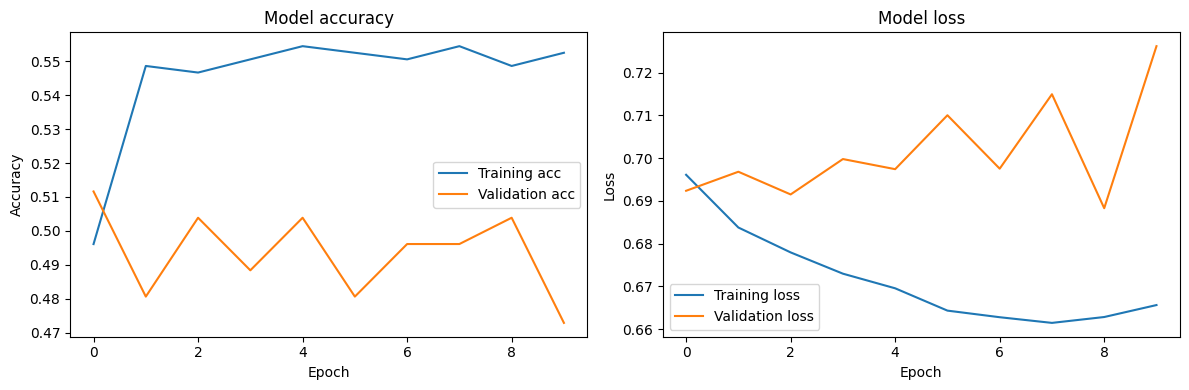

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training acc", "Validation acc"], loc= "center right")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training loss", "Validation loss"], loc= "lower left")

plt.tight_layout()
plt.show()